To Do List:

- keep observed frame since parameters (disp) is measured in obs frame!
- Function to create input/output directories                         

In [2]:
# header

import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib.colors import LogNorm
from scipy.optimize import nnls
from astropy.io import fits
from astropy.table import Table
from astropy.modeling import models, fitting
from astropy.cosmology import WMAP9 as cosmo
from astropy import units as u
from maoppy.psfmodel import Psfao, psffit
from maoppy.instrument import muse_nfm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
import warnings

import warnings

In [3]:
def colorbar(mappable,orientation="vertical",ticks=None,label=None, fontsize=14,format=None):
    
        ax = mappable.axes
        fig = ax.figure
        divider = make_axes_locatable(ax)
        if orientation=='vertical':
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cax.tick_params(length=5,width=1,labelsize=.8*fontsize)
            
            cb=fig.colorbar(mappable, cax=cax,orientation=orientation,format=format)
            cb.set_label(label, labelpad=5, fontsize=fontsize)
            
        elif orientation=='horizontal':
            cax = divider.append_axes("top", size="5%", pad=0.05)
            cax.xaxis.set_label_position('top')
            cax.xaxis.set_ticks_position('top')
            cax.tick_params(bottom=False, top=True, length=5,width=1, pad=-22, labelsize=.8*fontsize)
        
            cb=fig.colorbar(mappable, cax=cax,orientation=orientation,format=format)
            cb.set_label(label, labelpad=-45, fontsize=fontsize)
            
        return cb
        
def my_scalebar(ax,cz,loc=(0.5,0.5),c='k',distance='50pc'):
    
    xextent = ax.get_xlim()[1] - ax.get_xlim()[0]
    yextent = ax.get_ylim()[1] - ax.get_ylim()[0]
    
    arcsec_per_kpc = 1/cosmo.kpc_proper_per_arcmin(cz/3e5).value*60*1e3
    size_vertical=1e-2*yextent
    
    height = 3e-2*yextent
    
    if distance=='50pc':
        width = .05*arcsec_per_kpc
        label = r'$50\,$pc'
        
    elif distance=='100pc':
        width = .1*arcsec_per_kpc
        label = r'$100\,$pc'
    
    elif distance=='500pc':
        width = .5*arcsec_per_kpc
        label = r'$500\,$pc'

    elif distance=='1kpc':
        width = 1*arcsec_per_kpc
        label =  r'$1\,$kpc'
    
    elif distance=='5kpc':
        width = 5*arcsec_per_kpc
        label =  r'$5\,$kpc'
        
    elif distance=='10kpc':
        width = 10*arcsec_per_kpc
        label =  r'$10\,$kpc'
    
    else:
        raise ValueError('Specify distance scale!')
  
    xy = (loc[0]-width/xextent/2, loc[1]-height/yextent/2)
    
    rect = patches.Rectangle(xy, width/xextent, height/yextent, linewidth=1, edgecolor=c, 
                             facecolor=c, transform=ax.transAxes)
    
    ax.add_patch(rect)
    
    tloc = (loc[0],xy[1]-3*(height/yextent))
    ax.text(*tloc,label,c=c,fontsize=15, ha='center', va='center', transform=ax.transAxes)

In [4]:
class Header(object):
    def __init__(self, header=None, origin=None):
        """
            Creates an Header object
            
            Parameters
            --------------
            header : fits.header object, optional
                    Fits header as header
            origin : string, optional
                    Name of the Fits file as the origin for the header,
                    can be the full path of the file
                       
        """
        if header is not None:
            # Assign private variable and convert header to card list
            self.header = header
        else:
            # Create empty Header and CardList objects
            self.header = None
        
        # Set the Fits file origin of the header if given
        if origin is not None:
            self.origin = origin
        else:
            self.origin = None
            
    def setHeader(self, header, origin=None):
        self.header = header
        self.origin = origin
    
    def loadFitsHeader(self, filename,  extension=0):
        """
            Loads the header information from a Fits file
            
            Parameters
            ---------------
            filename : string
                        Filename of the Fits file from which the header should be loaded.
                        The full path to the file can be given.
            extension : integer, optional
                        Extension of the Fits file from the header shall be read
        """
        self.header = fits.getheader(filename, ext=extension)
        self.origin = filename
        
    def writeFitsHeader(self, filename=None, extension=0):
        """
            Writes the header to an existing Fits file
            
            Parameters:
            ---------------
            filename : string, optional
                        Filename of the Fits file to which the header is written.
                        The full path to the file can be given.
                        If filename is none, the value of _origin ise used.
            extenstion : integer, optional
                        Extension of the Fits file to which the header is written.
        """
        
        if filename is None:
            f_out = self.origin
        else:
            f_out = filename
        hdu = fits.open(f_out, mode='update')
        hdu[extension].header = self.header
        hdu[extension].update_header()
        hdu.flush()

    def getHdrValue(self, keyword):
        """
            Returns the value of a certain keyword in the header
        
            Parameters:
            ---------------
            keyword : string
                        valid keyword in the header
            
            Returns:
            ---------------
            out : string, integer or float
                        stored value in the header for the given keyword
        """
        return self.header[keyword]

    def getHdrKeys(self):
        """
            Returns all valid keywords of the Header
        
            Returns:
            ---------------
            out : list
                        list of strings representing the keywords in the header
        """
        return self.header.keys()
        
        
    def setHdrValue(self,  keyword,  value,  comment=None):
        """
            Sets the value of a certain keyword in the header
        
            Parameters:
            ---------------
            keyword : string
                        valid keyword in the header
        """
        if self.header is None:
            self.header = fits.Header()
        if comment is None:
            try:
                self.header.update(keyword, value)
            except ValueError:
                self.header[keyword] = (value)
        else:
            try:
                self.header.update(keyword, value, comment)
            except ValueError:
                self.header[keyword] = (value, comment)

In [5]:
class Cube(Header):
    
    """
    A class representing 3D spectra.

    `Cube` is a subclass of Data which allows for handling and organizing a
    three-dimensional spectrum. The class supports reading and writing FITS
    files, resampling and rebinning, velocity shifting and broadening, the
    application of extinction corrections and various advanced fitting
    functions.

    Parameters
    ----------
    data : `np.ndarray`
        The spectra as a 2D np array structured such that the different
        spectra are located along the second and third dimension.
    wvl : `np.ndarray`
        The wavelength elements corresponding to the different data points
        along the third dimension of the `data`.
    error : `np.ndarray`, optional
        The error spectrum, should be of the same shape as `data`.
        If `error` equals None, it is assumed the error spectrum is not
        known.
    mask : `np.ndarray`
        A boolean array where True represents a masked (invalid) data point
        and False a good data point. Should be of the same shape as `data`.
    normalization : `np.ndarray`
        An array which is used to normalize the data/error; both data and
        error are divided by `normalization`. Should be of the same shape
        as `data`.
    inst_fwhm : float
        The instrumental FWHM in the same units as `wavelength`.
    header : Header, optional
        Contains information for reading and writing data to and from Fits
        files.
    """
    
    def __init__(self, header=None, data=None, wvlrf=None, error=None, mask=None, ncrop=14):
        
        Header.__init__(self, header=header)
        self.ncrop = ncrop
        
    def get_minicube(self, wvl_min=4750, wvl_max=5100, ncrop=14):
        
        """
            Truncates the initial data cube in both wavelength
            and spatial dimension.
            The resulting minicube has a shape of [something,ncrop,ncrop]
            and has the brightest pixel in its center
        """
        
        # crop wvl axis in rest frame
        select = ((self.wvl>wvl_min) & (self.wvl<wvl_max))
        
        self.data = self.data[select]
        self.error = self.error[select]
        self.wvl = self.wvl[select]
        
        # find flux maximum as qso position
        ycen, xcen = np.unravel_index(np.nanargmax(np.nansum(self.data, axis=0)), self.data.shape[1:])
    
        # crop spatial axis
        s = ncrop//2
        self.data = self.data[:,(ycen-s):(ycen+s),(xcen-s):(xcen+s)]
        self.error = self.error[:,ycen-s:ycen+s,xcen-s:xcen+s]
    
        
    def loadFitsCube(self, filename, cz=None,extension_hdr=None, extension_data=None, 
                     extension_mask=None, extension_error=None,
                     extension_errorweight=None, extensionProjects_hdr=0):
        
        """
            Load data from a FITS image into a Data object

            Parameters
            --------------
            filename : string
                Name or Path of the FITS image from which the data shall be loaded


            extension_hdr : int or string, optional with default: None
                Number or name of the FITS extension containing the fits header to be used for the cube information like
                wavelength or WCS system.

            extension_data : int or string, optional with default: None
                Number or name of the FITS extension containing the data

            extension_error : int or string, optional with default: None
                Number or string of the FITS extension containing the errors for the values

            extension_mask : int or string, optional with default: None
                Number or name of the FITS extension containing the masked pixels
        """

        hdu = fits.open(filename)
        self.header = hdu[extension_hdr].header
        self.data = hdu[extension_data].data/1e4

        if hdu[extension_error].header['EXTNAME'].split()[0] == 'STAT':
                self.error = np.sqrt(hdu[extension_error].data)/1e4
        elif hdu[extension_error].header['EXTNAME'].split()[0] == 'ERROR':
                self.error = hdu[extension_error].data/1e4
        else:
            print('First extension is neither ERROR nor STAT')

        self.dim = self.data.shape

        try:
            self.wvl = self.header['CDELT3']*np.arange(self.dim[0]) + self.header['CRVAL3']
        except:
            self.wvl = self.header['CD3_3']*np.arange(self.dim[0]) + self.header['CRVAL3']
        
        else:
            pass

        self.wvl /=(1+cz/3e5)
   
        hdu.close()

In [8]:
class Astrometry(Cube):
    
    """
    A class which performs a spectroastrometry of the emission lines
    present in the AGN data cube.

    Parameters
    ----------
    cubefile : `string`
        path to the original datacube
    eline_table : `string`
        path to the output file from the AGN fitting 
    """
        
        
    def __init__(self, cubefile, eline_table, cz):
        
        self.cz = cz
        self.redshift = self.cz/3e5
        self.elines = [  'Hb_broad','Hb_medium', 'Hb_core', 'Hb_wing',
                         'FeII4924_medium','FeII4924_broad',
                         'FeII5018_medium','FeII5018_broad',
                         'OIII4959_core', 'OIII4959_wing',
                         'OIII5007_core', 'OIII5007_wing',
                      ]
            
        self.components = {'broad':['Hb_broad', 'Hb_medium', 
                                    'FeII4924_medium','FeII4924_broad', 
                                    'FeII5018_medium','FeII5018_broad'],
                           'core_Hb':['Hb_core'],
                           'core_OIII':['OIII4959_core', 'OIII5007_core'],
                           'wing_Hb':['Hb_wing'],
                           'wing_OIII':['OIII4959_wing', 'OIII5007_wing']
                  }
        
        self.setup_rcparams()
        self.cube = Cube()
        self.cube.loadFitsCube(cubefile,cz=self.cz, extension_hdr=1, extension_data=1, extension_error=2)
        self.cube.get_minicube()  # get minicube centered at AGN location
        self.wvl = self.cube.wvl
        self.qso_loc, self.qso_spectrum, self.qso_error = self.get_qso_spectrum(self.cube.data, self.cube.error)
        self.qso_eline, self.continuum = self.subtract_continuum(self.wvl, self.qso_spectrum)
        
        # read in best fit parameters QSO spectrum model
        self.qsotable = self.read_in_table(eline_table)
        
        # initialize astropy models from best fit parameters
        self.eline_models = self.setup_eline_models(self.wvl, self.qsotable)
        
        # combine astropy moodels 
        print('Setup basis')
        self.basis_models = self.setup_basis_models(self.eline_models, self.components)
        
        # initialize arrays containing normalized spectra for components
        self.basis = self.setup_basis_arrays(self.wvl, self.basis_models)
        
        # fit components to cube
        print('Fit components to cube')
        self.flux, self.dflux = self.fit_cube(self.wvl, self.cube.data, self.cube.error)
        
        # find PSF model parameters
        print('Find PSF model parameters')
        self.PSF_image, self.PSF_param = tqdm(self.get_PSF_param('Hb'))
        
        # fit model position
        print('Find centroids')
        self.model = self.findpos()
        
        
    def read_in_table(self,file):
        
        """
            Reads table that contains parameters of the QSO spectrum model
            
            Parameters
            ----------
            file : `string`
                file path of eline table
                
            Returns
            -------
            table: `astropy.table`
                astropy table with data from eline table file
        """
        
        hdul = fits.open(file)
        table = Table(hdul[1].data)

        return table
    
        
    def get_qso_spectrum(self, data, error):
        
        """
            Reads table that contains parameters of the QSO spectrum model
            
            Parameters
            ----------
            data : `numpy array`
                data cube
            error : `numpy array`
                error cube
                
            Returns
            -------
            qso_loc: `tuple`
                (x,y) coordinates of AGN in data cube
            qso_spec: `numpy array`
                1D spectrum extracted from the AGN spaxel
            qso_err: `numpy array`
                1D error spectrum extracted from the AGN spaxel
                
        """
            
        # returns position and spectrum brightest pixel
    
        white_image = np.nansum(data, axis=0)
        qso_loc = np.unravel_index(np.nanargmax(white_image), white_image.shape)
        qso_spec = data[:,qso_loc[0], qso_loc[1]]
        qso_err = error[:,qso_loc[0], qso_loc[1]]
        
        return qso_loc, qso_spec, qso_err
    
    
    def subtract_continuum(self,wvl,spectrum):
        
        """
            Extract and subtract linear continuum in the Hb window
            by defining two regions in the rest-frame 
            (blue from Hb, red from [OIII])
            returns the continuum-subtracted emission lines and the continuum
            
            Parameters
            ----------
            wvl : `numpy array`
                wavelength array
            spectrum : `numpy array`
                flux array, must be of the same dimesion as wvl
                
            Returns
            -------
            eline: `numpy array`
                continuum-subtracted spectrum
            cont: `numpy array`
                continuum
                
        """
        
        # extract and subtract linear continuum in the Hb window
        # by defining two regions in the rest-frame 
        # (blue from Hb, red from [OIII])
        # returns the continuum-subtracted emission lines and the continuum
        
        continuum_rf = {1:[4750,4755], 4:[5080,5090]}
        
        iscont = np.zeros(wvl.shape).astype(bool)
        for i in continuum_rf:
            iscont = iscont + ((wvl> continuum_rf[i][0]) & 
                                (wvl< continuum_rf[i][1])
                               )
        # initialize linear fitter
        fit = fitting.LinearLSQFitter()
        line_init=models.Polynomial1D(degree=1) 

        cont_model = fit(line_init, wvl[iscont], spectrum[iscont])
        cont = cont_model(wvl) 
        eline = spectrum - cont
        
        plt.plot(wvl, cont)
        plt.plot(wvl, spectrum)
        
        
        return eline, cont

    def setup_eline_models(self, wvl, qsotable):
        
        """
            Set up astropy models from initial guess parameters 
            in the AGNfit table
        
            Parameters
            ----------
            wvl : `numpy array`
                wavelength array
            qsotable : `astropy table`
                contains emission line parameters
                
            Returns
            -------
            eline_models: `dictionary`
                contains the Gaussian 1D models generated from the input eline table paramters
                
        """
        
        i = np.where(qsotable['parameter'] == 'amplitude')[0]
        j = np.where(qsotable['parameter'] == 'mean')[0]
        k = np.where(qsotable['parameter'] == 'stddev')[0]
    
        eline_models = type('', (), {})() # empty object
        
        for i in self.elines:
            param = qsotable[i]
            gauss = models.Gaussian1D(param[0],param[1],param[2])
            setattr(eline_models, i, gauss)
        
        return eline_models
    
    
    def setup_basis_models(self, gaussmodels, components):
        
        """
            This function combines models for which the flux ratio
            is known and was already fixed in the AGNfit.
            In this, basis_models contains all
            kinematically (and flux-) tied base components
        
            Parameters
            ----------
            gaussmodels : `astropy models`
                emission line models
            components : `strings`
                names of the kinematic components which may contain several different emission 
                line components
                
            Returns
            -------
            basis_models: `astropy models`
                collection of kinematic components
        """
        
        basis_models = type('', (), {})()
        
        for component in components:
            
            # get all elines that belong to that component
            basemodels = np.full(len(components[component]), models.Gaussian1D())
            for idx, eline in enumerate(components[component]):
                basemodels[idx] = getattr(self.eline_models, eline)
            
            # combine the eline models
            for idx in range(len(basemodels))[1:]: 
                basemodels[0] += basemodels[idx]
                
            setattr(basis_models, component, basemodels[0]) 
            
        return basis_models

                
    def setup_basis_arrays(self, wvl, models):
        
        """
            Evaluates the model for a given wavelength array
            returns normalized spectrum for the base components
            i.e. broad, core_Hb, core_OIII, wing_Hb, wing_OIII

            returns arrays that are normalized to the peak flux 
            of the resp. component
        
            Parameters
            ----------
            wvl : `numpy array`
                wavelength array
            models : `astropy models`
                collection of kinematic components
                
            Returns
            -------
            basis: `arrays`
                collection of normalized spectrum of the 
                the respective kinematic component
        """

        basis = type('', (), {})() # empty object to store spetra
        
        for component in tqdm(self.components.keys()):
            spectrum = getattr(self.basis_models, component)(wvl)
            spectrum_norm = spectrum / np.nansum(spectrum)
        
            
            setattr(basis, component, spectrum_norm)
        
        return basis
    
    
    def fit_spectrum(self, wvl, spectrum, error):
        
        """
            fit an individual spectrum with the basis
        
            Parameters
            ----------
            wvl : `numpy array`
                wavelength
            spectrum : `numpy array`
                spectrum, must have the same dimension as wvl
            error : `numpy array`
                error, must have the same dimension as wvl
                
            Returns
            -------
            popt: `array`
                Optimal values for the parameters so that the sum 
                of the squared residuals of f(xdata, *popt) - ydata is minimized.
            model_spec: `array`
                best-fitting model spectrum. Has the same dimension as wvl
        """

        # Subtract continuum
        spec_eline, continuum = self.subtract_continuum(wvl,spectrum)
        
        A = np.zeros([wvl.shape[0],len(self.components.keys())])
   
        for idx,i in enumerate(self.components.keys()):
            A[:,idx] = getattr(self.basis, i)
            

        b = spec_eline
        w = 1/error
        wmatrix = np.full((5,w.shape[0]),w).T

        popt, rnorm= nnls(A*wmatrix, b*w)
        model_spec = np.zeros(spec_eline.shape)
        for idx,i in enumerate(self.components.keys()):
            
            model_spec += popt[idx]*getattr(self.basis, i) 
        
        return popt, model_spec
    
    def mock_spec(self, wvl, spectrum, error):
    
        """
            Generates an artifical spectrum by drawing a random flux from the 
            Gaussian probability distribution given by the flux measurement 
            and its error at each wavelength
        
            Parameters
            ----------
            wvl : `numpy array`
                wavelength
            spectrum : `numpy array`
                spectrum, must have the same dimension as wvl
            error : `numpy array`
                error, must have the same dimension as wvl
                
            Returns
            -------
            new_spectrum: `array`
                mock spectrum, has the same dimension as wvl
        """

        new_spectrum = np.array([np.random.normal(spectrum[i],error[i]) for i in np.arange(wvl.shape[0])])

        return new_spectrum
    
    
    def fit_cube(self, wvl, data, error):
        
        """
            Performs a linear fitting of the basis components 
            to each spectrum of the data cube 
        
            Parameters
            ----------
            wvl : `numpy array`
                wavelength
            spectrum : `numpy array`
                spectrum, must have the same dimension as wvl
            error : `numpy array`
                error, must have the same dimension as wvl
                
            Returns
            -------
            flux: `numpy array`
                Collection of 2D surface brightness maps for the kinematic components.
                Array has the shape [data.shape[1],data.shape[2],#components]
            dflux: `numpy array`
                Collection of 2D surface brightness errors for the kinematic components.
                Has the same shape as flux.
        """
        
        scalefactor_map = np.full([data.shape[1],data.shape[2],5], np.nan)
        dscalefactor_map = np.copy(scalefactor_map)

        for i in tqdm(np.arange(data.shape[1])):
            for j in np.arange(data.shape[2]):

                spec = data[:,i,j]
                err = error[:,i,j]
                error_expanded = np.full((5,err.shape[0]),err).T

                # linear regression
                # fit use fluxes as fitparameter rather than amplitudes!
                scalefactor,model_spectrum = self.fit_spectrum(wvl, spec, err)
                scalefactor_map[i,j] = scalefactor
                
                # MC error estimation
                scalefactor_mcmc=np.zeros((30,5))
                for k in np.arange(30):
                    spec_mcmc = self.mock_spec(wvl,spec,err)
                    scalefactork,_ =  self.fit_spectrum(wvl, spec_mcmc, err)
                    scalefactor_mcmc[k] = scalefactork

                dscalefactor = np.std(scalefactor_mcmc,axis=0)

                # store results in array
                scalefactor_map[i,j] = scalefactor
                dscalefactor_map[i,j] = dscalefactor
                
        # convert fit results from 3D array to self attributes
        
        flux = type('', (), {})()
        dflux = type('', (), {})()
        for idx,component in enumerate(self.components.keys()): 
            setattr(flux, component, scalefactor_map[:,:,idx])
            setattr(dflux, component, dscalefactor_map[:,:,idx])

        return flux, dflux
    
    
    def get_PSF_param(self, line):
        
        # fits PSFAO19 model to core band line form data cube
        # returns image of PSF, PSF parameters
        
        # find wavelength position in cube
        line = 'Hb'
        wvl_rf = {'Ha': 6563.8, 'Hb': 4861.4, '8450A': 8450}
        wavelength = wvl_rf[line]                              # wavelength [m]
    
        # initialize PSF model
        samp = muse_nfm.samp(wavelength*1e-10)                 # sampling (2.0 for Shannon-Nyquist)

        # fit the image with Psfao
        guess = [ 0.081, 1.07, 11.8, 0.06, 0.99, 0.016, 1.62]
        fixed = [False,False,False,False,False,False,False]
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            psfao = psffit(self.flux.broad,Psfao,guess,weights=1/(self.dflux.broad),
                           fixed=fixed,npixfit=14,                 # fit keywords
                           system=muse_nfm,samp=samp               # MUSE NFM keywords
                          ) 
        
        flux_fit, bck_fit = psfao.flux_bck
        fitao = flux_fit*psfao.psf + bck_fit
        parameters = psfao.x
        
        return fitao, np.array(parameters)
    
    
    def fit_PSFAO19(self,image,error):

        # fits PSFAO19 to an image
        # returns centroid position with errors
        
        if (np.nansum(image)==0) or (np.sum(error<=0)>0):
            image[image<=0] = 1e-19
            error[error<=0] = 1e19
        
        # find wavelength position in cube
        line = 'Hb'
        wvl_rf = {'Ha': 6563.8, 'Hb': 4861.4, '8450A': 8450}
        wavelength = wvl_rf[line]*(1+self.redshift) # wavelength [m]

        # initialize PSF model
        samp = muse_nfm.samp(wavelength*1e-10)                  # sampling (2.0 for Shannon-Nyquist)
        fixed = [True,True,True,True,True,True,True]
        
        out = psffit(image,Psfao,self.PSF_param,weights=1/error,fixed=fixed,
                     npixfit=image.shape[0],system=muse_nfm,samp=samp)
        
        fitao = out.flux_bck[0]*out.psf + out.flux_bck[1]
        dx=out.dxdy[0]
        dy=out.dxdy[1]
        
        # MC error
        dxdy_mcmc = np.zeros((20,2))
        
        for i in np.arange(20):
            image_mcmc = np.random.normal(image,error)
            out_mcmc = psffit(image_mcmc,Psfao,self.PSF_param,weights=1/error,
                              fixed=fixed,npixfit=image.shape[0], system=muse_nfm,samp=samp)
            dxdy_mcmc[i] = out_mcmc.dxdy


        ddx = np.std(dxdy_mcmc,axis=0)[0]
        ddy = np.std(dxdy_mcmc,axis=0)[1]
        
        position =  np.array([dx,dy,ddx,ddy])        
        
        return fitao, position
    
        
    def findpos(self):
        
        """
            Fits the PSF to the 2D light distribution for each of the kinematic components.
                
            Returns
            -------
            models: `attributes`
                contains (1) the image of the model surface brightness distribution and
                (2) a tuple with the coordinates of the centroid
        """
            
            
        models = type('', (), {})()
        for component in tqdm(self.components):
        
            image_fit,pos_fit = self.fit_PSFAO19(getattr(self.flux, component),
                                                 getattr(self.dflux, component)
                                                )
            
            model = type('', (), {})()
            model.image = image_fit
            model.centroid = pos_fit
            
            setattr(models, component, model)
            
            
        return models
    
    def offset(self,component):
        
        """
            this function computes the offset px 
            and from the PSF centroids from the BLR
            
            Parameters
            ----------
            component : `string`
                component for which the offset from the AGN position is computed
        """
        
        px = np.sqrt(  (self.model.broad.centroid[0] - getattr(self.model, component).centroid[0])**2 \
                     + (self.model.broad.centroid[1] - getattr(self.model, component).centroid[1])**2
                     )
        dpx = np.sqrt(  self.model.broad.centroid[2]**2 + getattr(self.model, component).centroid[2]**2 \
                      + self.model.broad.centroid[3]**2 + getattr(self.model, component).centroid[3]**2
                      )
       
        return px,dpx
    
    def print_result(self):
    
        """
            Prints the spectroastrometry result
        """
        
        for component in self.components:
            
            # [px]
            px,dpx = self.offset(component)
            
            # [arcsec]
            arcsec = px*0.025
            darcsec = dpx*0.025

            # [pc]
            d_obj = cosmo.comoving_distance(self.cz/3e5)
            pc = (d_obj*arcsec/206265).to(u.pc).value
            dpc = (d_obj*darcsec/206265).to(u.pc).value

            print('%15s  ' %(component)+ 
                  'd = (%.2f\u00B1%.2f) px ' %(px,dpx)
                  +' = (%.2f\u00B1%.2f) mas' %(arcsec*1e3,darcsec*1e3)
                  +' = (%.2f\u00B1%.2f) pc' %(pc,dpc)
                 )
            
        # print flux
        
        print('\n')
        for component in self.components:
            print('%15s  F = (%2.2f \u00B1% 2.2f) x %15s' %(component,
                                              np.nansum(getattr(self.flux, component)),
                                              np.nansum(getattr(self.dflux, component)),
                                             '10-16 ergs-1cm-2'
                                             )
                 )
            
    def write(self, path):
        
        """
            Write flux maps
            
            Parameters
            ----------
            path : `string`
                output directory
        """
        
        for component in self.components:
            
            fluxmap = getattr(astrometry.flux, component)
            dfluxmap = getattr(astrometry.dflux, component)
            modelmap = getattr(astrometry.model, component).image
            residuals = fluxmap-modelmap/getattr(astrometry.dflux, component) 
            
            hdu_primary = fits.PrimaryHDU()
            hdul = fits.HDUList([hdu_primary])
            hdul.append(fits.ImageHDU(fluxmap))
            hdul.append(fits.ImageHDU(dfluxmap))
            hdul.append(fits.ImageHDU(modelmap))
            hdul.append(fits.ImageHDU(residuals))
   
            
            for i in astrometry.cube.header:
                hdul[1].header[i] = astrometry.cube.header[i]
                        
            hdul[1].header['extname'] = 'Flux'
            hdul[2].header['extname'] = 'Flux_err'
            hdul[3].header['extname'] = 'PSFmodel'     
            hdul[4].header['extname'] = 'Residuals'    
            
            hdul.writeto(path+'Mrk1044_'+component+'.fits', overwrite=True)
            
            
    def setup_rcparams(self):
        
        """
            Specifies the runtime configuration settings for matplotlib.
            This function also defines a number of line styles.
        """
            
        mult = 1
        mpl.rcParams.update({'font.size': 15*mult})
        mpl.rcParams['legend.fontsize'] = 15*mult
        mpl.rcParams['axes.linewidth'] = 1
        mpl.rcParams['xtick.labelsize'] = 15*mult
        mpl.rcParams['ytick.labelsize'] = 15*mult
        mpl.rcParams['xtick.major.size'] = 5
        mpl.rcParams['ytick.major.size'] = 5
        mpl.rcParams['xtick.major.width'] = 1
        mpl.rcParams['ytick.major.width'] = 1
        mpl.rcParams['xtick.minor.size'] = 3
        mpl.rcParams['ytick.minor.size'] = 3
        mpl.rcParams['xtick.minor.width'] = 1
        mpl.rcParams['ytick.minor.width'] = 1
        mpl.rcParams['xtick.direction'] = 'in'
        mpl.rcParams['ytick.direction'] = 'in'
        mpl.rcParams['xtick.bottom'] = True
        mpl.rcParams['xtick.top'] = True
        mpl.rcParams['ytick.left'] = True
        mpl.rcParams['ytick.right'] = True
        mpl.rcParams['axes.labelsize'] = 15*mult
        mpl.rcParams['text.usetex'] = True
        
        self.ls = {
         'loosely dotted':        (0, (1, 10)),
         'dotted':                (0, (1, 1)),
         'densely dotted':        (0, (1, 1)),

         'loosely dashed':        (0, (5, 10)),
         'dashed':                (0, (5, 5)),
         'densely dashed':        (0, (5, 1)),

         'loosely dashdotted':    (0, (3, 10, 1, 10)),
         'dashdotted':            (0, (3, 5, 1, 5)),
         'densely dashdotted':    (0, (3, 1, 1, 1)),

         'dashdotdotted':         (0, (3, 5, 1, 5, 1, 5)),
         'loosely dashdotdotted': (0, (3, 10, 1, 10, 1, 10)),
         'densely dashdotdotted': (0, (3, 1, 1, 1, 1, 1))
         }

    
       
        
    def plot_spectrum(self,coor=None,gs=None,savefig=False):
        
        """
            Plots a spectrum from the minicube
            
            Parameters
            ----------
            coor : `tuple`
                (x,y) coordinates from where the spectrum in the cube will be extracted
            gs : `matplotlib.gridspec.GridSpec` [optional]
                optional, existing GridSpec to which the plot will be added
            savefig : `boolean` [optional]
                saves plot as .png file
        """
            
        # get base spectra (normalized to 1 erg-scm-2) and
        # approx. rescale to maximum flux density of the AGN spectrum
        broad_init = self.basis.broad
        broad_init = broad_init/np.nanmax(self.basis.broad)*.3*np.nanmax(self.qso_spectrum)
        core_init = self.basis.core_Hb+self.basis.core_OIII
        core_init = core_init/np.nanmax(core_init)*.3*np.max(self.qso_spectrum)  
        wing_init = self.basis.wing_Hb+self.basis.wing_OIII
        wing_init = wing_init/np.nanmax(wing_init)*.3*np.max(self.qso_spectrum)  
        
        # fit result, scaled to qso_spectrum
        broad_fit =  self.flux.broad[coor[0],coor[1]]*self.basis.broad
        core_fit =   self.flux.core_Hb[coor[0],coor[1]]*self.basis.core_Hb \
               + self.flux.core_OIII[coor[0],coor[1]]*self.basis.core_OIII
        wing_fit =   self.flux.wing_Hb[coor[0],coor[1]]*self.basis.wing_Hb \
               + self.flux.wing_OIII[coor[0],coor[1]]*self.basis.wing_OIII
        _,continuum_fit = self.subtract_continuum(self.wvl, self.cube.data[:,coor[0],coor[1]])
        model_fit = continuum_fit + broad_fit + core_fit + wing_fit
        
        spec = self.cube.data[:,coor[0],coor[1]]
        err = self.cube.error[:,coor[0],coor[1]]
        res = spec-model_fit
        
        
        #         *** plotting***
        
        # init model
        
        xlabel=r'rest-frame wavelength $\lambda \, [\rm{\AA}]$'
        ylabel=r'$f_\lambda \,\, [10^{-16} \rm{erg/s/cm}^{2}/\rm{A}]$'
        rwindow=5
        
        if gs==None:
            
            fig,axes=plt.subplots(figsize=(8,8),dpi=100)
            gs = gridspec.GridSpec(2,1, height_ratios = [1, 1.2], hspace=0) 
            
        gs0 = gridspec.GridSpecFromSubplotSpec(1, 1,subplot_spec = gs[0],hspace=0)
        gs1 = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec = gs[1], height_ratios = [rwindow, 1],hspace=0)
        
        
        ax0 = plt.subplot(gs0[0])
        ax0.step(self.wvl+.5*1.25,self.qso_spectrum, 
                 linewidth=1, color='k', label='AGN')
        ax0.plot(self.wvl,broad_init, color='cornflowerblue',
                 linestyle=self.ls['densely dashed'], linewidth=.8, label = 'broad')
        ax0.plot(self.wvl,core_init,  color='lightcoral',
                 linestyle=self.ls['densely dashdotted'], linewidth=.8, label='core')
        ax0.plot(self.wvl,wing_init,  color='limegreen',
                 linestyle=self.ls['densely dashdotdotted'], linewidth=.8, label='wing')
        ax0.legend(fontsize=10)
        ax0.set_xlim(min(self.wvl),max(self.wvl))
        ax0.set_ylim(1e-4*np.nanmax(self.qso_spectrum))

        
     
        # fit result
        ax1 = plt.subplot(gs1[0])
        ax1.step(self.wvl+.5*1.25, spec, color='k', linewidth=1, label='AGN')
        ax1.fill_between(self.wvl,broad_fit, facecolor='cornflowerblue', label = 'broad')
        ax1.fill_between(self.wvl,core_fit, facecolor='lightcoral', label='core')
        ax1.fill_between(self.wvl,wing_fit, facecolor='limegreen', label='wing')
        ax1.plot(self.wvl, model_fit, linewidth=1 , c='firebrick', label = 'model')
        ax1.legend(fontsize=10)
        ax1.set_xlim(min(self.wvl),max(self.wvl))
        ax1.set_ylim(1e-4*np.nanmax(spec))

        
        # residuals
        ax2 = plt.subplot(gs1[1])
        ax2.step(self.wvl+.5*1.25, res/err, color='k', linewidth=1)
        ax2.fill_between(self.wvl+.5*1.25, -3,3, color='firebrick', edgecolor='white', alpha=.2)
        ax2.set_xlim(min(self.wvl),max(self.wvl))
        ax2.set_ylim(-6,6)

        
        # plot parameters
        
        # ticks
        ax0.tick_params(axis='both',labelbottom=False)
        ax1.tick_params(axis='both',labelbottom=False)

        # labels
        if gs==None:
            ax0.set_ylabel(r'$f_\lambda \,\, [10^{-16} \rm{erg/s/cm}^{2}/\rm{\AA}]$')
            ax1.set_ylabel(r'$f_\lambda \,\, [10^{-16} \rm{erg/s/cm}^{2}/\rm{\AA}]$')
        else:
            ax1.set_ylabel(r'$f_\lambda \,\, [10^{-16} \rm{erg/s/cm}^{2}/\rm{\AA}]$')
            ax1.yaxis.set_label_coords(-.12,.95)
        ax2.set_xlabel(xlabel)
        ax2.set_ylabel(r'$\frac{\rm residual}{\rm error}$')
        
        ax0.xaxis.set_minor_locator(AutoMinorLocator())
        ax0.yaxis.set_minor_locator(AutoMinorLocator())
        ax1.xaxis.set_minor_locator(AutoMinorLocator())
        ax1.yaxis.set_minor_locator(AutoMinorLocator())
        ax2.xaxis.set_minor_locator(AutoMinorLocator())
        ax2.yaxis.set_minor_locator(AutoMinorLocator())
        
        
        
        if savefig:
            plt.savefig('Figures/spectroastrometry_spec.png',bbox_inches='tight', dpi=300)
            
            
    
    def plot_maps(self,gs=None,savefig=False):
    
        """
            Plots maps of the kinematic components 
            
            Parameters
            ----------
            gs : `matplotlib.gridspec.GridSpec` [optional]
                existing GridSpec to which the plot will be added
            savefig : `boolean` [optional]
                saves plot as .png file
        """
        
        extent=np.array([-(self.cube.ncrop)/2,(self.cube.ncrop)/2,
                             -(self.cube.ncrop)/2,(self.cube.ncrop)/2
                            ]
                           )
        
        extent*=0.025*1e3 # implement cellsize in cube!
        
        
        if gs==None:
            fig = plt.figure(figsize=(9, 6), dpi=150)
            gs = gridspec.GridSpec(3,3,wspace=.07, hspace=.06, width_ratios=[1,1,1.1])
        
        
        # Flux maps
        
        component='broad'
        fluxmap = getattr(self.flux, component)
        ax00 = plt.subplot(gs[0,0]) 
        cmap = mpl.cm.get_cmap('gist_earth_r')
        im = ax00.imshow(fluxmap/np.nanmax(fluxmap), origin='lower',extent=extent,cmap=cmap,
                       norm=LogNorm(vmin=2e-2, vmax=1)) 
        my_scalebar(ax00, cz, c='k', loc=(.5,.22), distance='50pc')
            
        component='core_OIII'
        fluxmap = getattr(self.flux, component)
        ax01 = plt.subplot(gs[0,1]) 
        cmap = mpl.cm.get_cmap('gist_earth_r')
        im = ax01.imshow(fluxmap/np.nanmax(fluxmap), origin='lower',extent=extent,cmap=cmap,
                       norm=LogNorm(vmin=2e-2, vmax=1)) 
        my_scalebar(ax01, cz, c='k', loc=(.5,.22), distance='50pc')
        
        component='wing_OIII'
        fluxmap = getattr(self.flux, component)
        ax02 = plt.subplot(gs[0,2]) 
        cmap = mpl.cm.get_cmap('gist_earth_r')
        im = ax02.imshow(fluxmap/np.nanmax(fluxmap), origin='lower',extent=extent,cmap=cmap,
                       norm=LogNorm(vmin=2e-2, vmax=1)) 
        #my_scalebar(ax02, cz, c='k', loc=(.5,.22), distance='50pc')
        cbarlabel = r'$ \Sigma$'
        colorbar(im,label=cbarlabel)
            
            
        # PSF maps
        
        component='broad'
        fluxmap = getattr(self.model, component).image
        ax10 = plt.subplot(gs[1,0]) 
        cmap = mpl.cm.get_cmap('gist_earth_r')
        im = ax10.imshow(fluxmap/np.nanmax(fluxmap), origin='lower',extent=extent,cmap=cmap,
                       norm=LogNorm(vmin=2e-2, vmax=1)) 
        #my_scalebar(ax10, cz, c='k', loc=(.5,.18), distance='50pc')
        
        component='core_OIII'
        fluxmap = getattr(self.model, component).image
        ax11 = plt.subplot(gs[1,1]) 
        cmap = mpl.cm.get_cmap('gist_earth_r')
        im = ax11.imshow(fluxmap/np.nanmax(fluxmap), origin='lower',extent=extent,cmap=cmap,
                       norm=LogNorm(vmin=2e-2, vmax=1)) 
        #my_scalebar(ax10, cz, c='k', loc=(.5,.18), distance='50pc')
        
        component='wing_OIII'
        fluxmap = getattr(self.model, component).image
        ax12 = plt.subplot(gs[1,2]) 
        cmap = mpl.cm.get_cmap('gist_earth_r')
        im = ax12.imshow(fluxmap/np.nanmax(fluxmap), origin='lower',extent=extent,cmap=cmap,
                       norm=LogNorm(vmin=2e-2, vmax=1)) 
        #my_scalebar(ax12, cz, c='k', loc=(.5,.18), distance='50pc')
        cbarlabel = r'$ \Sigma$'
        colorbar(im,label=cbarlabel)
        
        # Residual maps
        
        component='broad'
        fluxmap = getattr(self.model, component).image
        dfluxmap = getattr(self.dflux, component)
        residuals = (  getattr(self.flux, component) 
                     - getattr(self.model, component).image
                    ) /getattr(self.flux, component) 
        ax20 = plt.subplot(gs[2,0]) 
        cmap = mpl.cm.get_cmap('seismic')
        im = ax20.imshow(residuals, origin='lower',extent=extent,cmap=cmap,vmin=-1, vmax=1) 
        my_scalebar(ax20, cz, c='k', loc=(.5,.22), distance='50pc')
    
        component='core_OIII'
        fluxmap = getattr(self.flux, component)
        dfluxmap = getattr(self.dflux, component)
        residuals = (  getattr(self.flux, component) 
                     - getattr(self.model, component).image
                    ) /getattr(self.flux, component) 
        ax21 = plt.subplot(gs[2,1]) 
        cmap = mpl.cm.get_cmap('seismic')
        im = ax21.imshow(residuals, origin='lower',extent=extent,cmap=cmap,vmin=-1, vmax=1) 
        my_scalebar(ax21, cz, c='k', loc=(.5,.22), distance='50pc')
        
        component='wing_OIII'
        fluxmap = getattr(self.flux, component)
        dfluxmap = getattr(self.dflux, component)
        residuals = (  getattr(self.flux, component) 
                     - getattr(self.model, component).image
                    ) /getattr(self.flux, component) 
        ax22 = plt.subplot(gs[2,2]) 
        cmap = mpl.cm.get_cmap('seismic')
        im = ax22.imshow(residuals, origin='lower',extent=extent,cmap=cmap,vmin=-1, vmax=1) 
        my_scalebar(ax22, cz, c='k', loc=(.5,.22), distance='50pc')
        cbarlabel = 'residual/error'
        colorbar(im,label=cbarlabel)
                
            
            
        # draw borad centroids
        ax00.scatter(*self.model.broad.centroid[:2]*0.025*1e3, marker='x', c='firebrick', s=40)
        ax01.scatter(*self.model.core_Hb.centroid[:2]*0.025*1e3, marker='x', c='gold', s=40)
        ax01.scatter(*self.model.broad.centroid[:2]*0.025*1e3, marker='x', c='firebrick', s=40)
        ax02.scatter(*self.model.wing_OIII.centroid[:2]*0.025*1e3, marker='x', c='gold', s=40, label='centroid')
        ax02.scatter(*self.model.broad.centroid[:2]*0.025*1e3, marker='x', c='firebrick', s=40, label='AGN')
        legend = ax02.legend(fontsize=8, bbox_to_anchor=(0.95,0.3),framealpha=.5)
        legend.get_frame().set_alpha(.4)
        
        # annotations
        ax00.annotate('(a)', ha='left',   xy=(0.1, 0.85), fontsize=14, xycoords='axes fraction')
        
        ax00.annotate(r'H$\beta$ broad',  xy=(0.9, 0.85), fontsize=14, ha='right', xycoords='axes fraction')
        ax00.annotate(r'Data',  xy=(0.9, .7), fontsize=14, ha='right', xycoords='axes fraction')
        ax01.annotate('(b)', ha='left',   xy=(0.1, 0.85), fontsize=14, xycoords='axes fraction')
        ax01.annotate(r'[O$\:$III] core', xy=(0.9, 0.85), fontsize=14, ha='right', xycoords='axes fraction')
        ax02.annotate('(c)', ha='left',   xy=(0.1, 0.85), fontsize=14, xycoords='axes fraction')
        ax02.annotate(r'[O$\:$III] wing', xy=(0.9, 0.85), fontsize=14, ha='right', xycoords='axes fraction')
        ax10.annotate('(d)', ha='left',   xy=(0.1, 0.85), fontsize=14, xycoords='axes fraction')
        ax10.annotate('Model', ha='right',   xy=(0.9, 0.85), fontsize=14, xycoords='axes fraction')
        ax11.annotate('(e)', ha='left',   xy=(0.1, 0.85), fontsize=14, xycoords='axes fraction')
        ax12.annotate('(f)', ha='left',   xy=(0.1, 0.85), fontsize=14, xycoords='axes fraction')
        ax20.annotate('(g)', ha='left',   xy=(0.1, 0.85), fontsize=14, xycoords='axes fraction')
        ax20.annotate('Residual', ha='right',   xy=(0.9, 0.85), fontsize=14, xycoords='axes fraction')
        ax21.annotate('(h)', ha='left',   xy=(0.1, 0.85), fontsize=14, xycoords='axes fraction')
        ax22.annotate('(i)', ha='left',   xy=(0.1, 0.85), fontsize=14, xycoords='axes fraction')
        
        
        # switch on minor ticks
        ax00.xaxis.set_minor_locator(AutoMinorLocator())
        ax00.yaxis.set_minor_locator(AutoMinorLocator())
        ax01.xaxis.set_minor_locator(AutoMinorLocator())
        ax01.yaxis.set_minor_locator(AutoMinorLocator())
        ax02.xaxis.set_minor_locator(AutoMinorLocator())
        ax02.yaxis.set_minor_locator(AutoMinorLocator())
        ax10.xaxis.set_minor_locator(AutoMinorLocator())
        ax10.yaxis.set_minor_locator(AutoMinorLocator())
        ax11.xaxis.set_minor_locator(AutoMinorLocator())
        ax11.yaxis.set_minor_locator(AutoMinorLocator())
        ax12.xaxis.set_minor_locator(AutoMinorLocator())
        ax12.yaxis.set_minor_locator(AutoMinorLocator())
        ax20.xaxis.set_minor_locator(AutoMinorLocator())
        ax20.yaxis.set_minor_locator(AutoMinorLocator())
        ax21.xaxis.set_minor_locator(AutoMinorLocator())
        ax21.yaxis.set_minor_locator(AutoMinorLocator())
        ax22.xaxis.set_minor_locator(AutoMinorLocator())
        ax22.yaxis.set_minor_locator(AutoMinorLocator())
        
        
        ax01.tick_params(axis='both', labelleft=False)
        ax02.tick_params(axis='both', labelleft=False)
        ax11.tick_params(axis='both', labelleft=False)
        ax12.tick_params(axis='both', labelleft=False)
        ax21.tick_params(axis='both', labelleft=False)
        ax22.tick_params(axis='both', labelleft=False)
        ax00.tick_params(axis='both', labelbottom=False)
        ax01.tick_params(axis='both', labelbottom=False)
        ax02.tick_params(axis='both', labelbottom=False)
        ax10.tick_params(axis='both', labelbottom=False)
        ax11.tick_params(axis='both', labelbottom=False)
        ax12.tick_params(axis='both', labelbottom=False)
    
        ax00.set_ylabel(r'$\Delta \,  \delta \,[{\rm mas}]$', labelpad=-7)
        ax10.set_ylabel(r'$\Delta \,  \delta \,[{\rm mas}]$', labelpad=-7)
        ax20.set_ylabel(r'$\Delta \,  \delta \,[{\rm mas}]$', labelpad=-7)
        ax20.set_xlabel(r'$\Delta \,  \alpha \,[{\rm mas}]$')
        ax21.set_xlabel(r'$\Delta \,  \alpha \,[{\rm mas}]$')
        ax22.set_xlabel(r'$\Delta \,  \alpha \,[{\rm mas}]$')

        if savefig:
            plt.savefig('Output/spectroastrometry_maps.png',bbox_inches='tight')
            
            
    def plot_all(self,coor):
        
        """
            Plots both spectra before/after fitting together with the
            surface brightness maps of the kinematic components 
            
            Parameters
            ----------
            coor : `tuple`
                (x,y) coordinates from where the spectrum in the cube will be extracted
        """
            
        fig = plt.figure(figsize=(15, 7), dpi=150)
        outer = gridspec.GridSpec(1,2,wspace=0.2, width_ratios=[2.5,3]) 
        
        inner1 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec = outer[0], 
                                                  height_ratios = [1, 1.2], hspace=0) 
        inner2 = gridspec.GridSpecFromSubplotSpec(3,3, subplot_spec = outer[1], 
                                                  wspace=.07, hspace=.06, width_ratios=[1,1,1.1])
        
        self.plot_spectrum(astrometry,[2,2],gs=inner1,savefig=False)
        self.plot_maps(astrometry,gs=inner2,savefig=False)
        
        return fig

# Mock Data Cube

Setup basis


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 1482.51it/s]


Fit components to cube


100%|███████████████████████████████████████████| 14/14 [00:17<00:00,  1.22s/it]


Find PSF model parameters


100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]


Find centroids


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


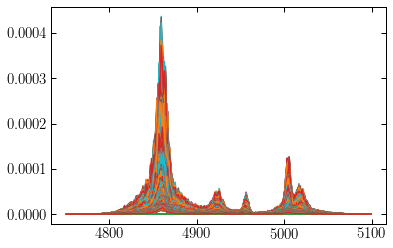

In [9]:
# Mock Data Cube
cz = 4913.4
cellsize=.025
dirname = 'MockCube/'
objectname = 'MockCube'

root = '/home/winkel/Projects/MUSE_NFM_AGN/08_Spectroastrometry/Data/MockCube/'
cubefile = root+'MockCube_0.1_0.fits'

root2 = '/home/winkel/Projects/MUSE_NFM_AGN/'
dirname = 'HE0227-0913/'
objectname = 'Mrk1044'
qsotablefile = root2+'02_AGN/02_Fitting/Data/'+dirname+objectname +'.central_fit.full.fits'

mock_astrometry = Astrometry(cubefile, qsotablefile, cz)

In [16]:
mock_astrometry.print_result()

          broad  d = (0.00±0.01) px  = (0.00±0.13) mas = (0.00±0.04) pc
        core_Hb  d = (0.12±0.09) px  = (3.01±2.32) mas = (1.03±0.79) pc
      core_OIII  d = (0.01±0.02) px  = (0.33±0.40) mas = (0.11±0.14) pc
        wing_Hb  d = (0.08±0.06) px  = (2.06±1.54) mas = (0.71±0.53) pc
      wing_OIII  d = (0.05±0.02) px  = (1.36±0.58) mas = (0.47±0.20) pc


          broad  F = (0.18 ± 0.00) x 10-16 ergs-1cm-2
        core_Hb  F = (0.01 ± 0.00) x 10-16 ergs-1cm-2
      core_OIII  F = (0.02 ± 0.00) x 10-16 ergs-1cm-2
        wing_Hb  F = (0.01 ± 0.00) x 10-16 ergs-1cm-2
      wing_OIII  F = (0.00 ± 0.00) x 10-16 ergs-1cm-2


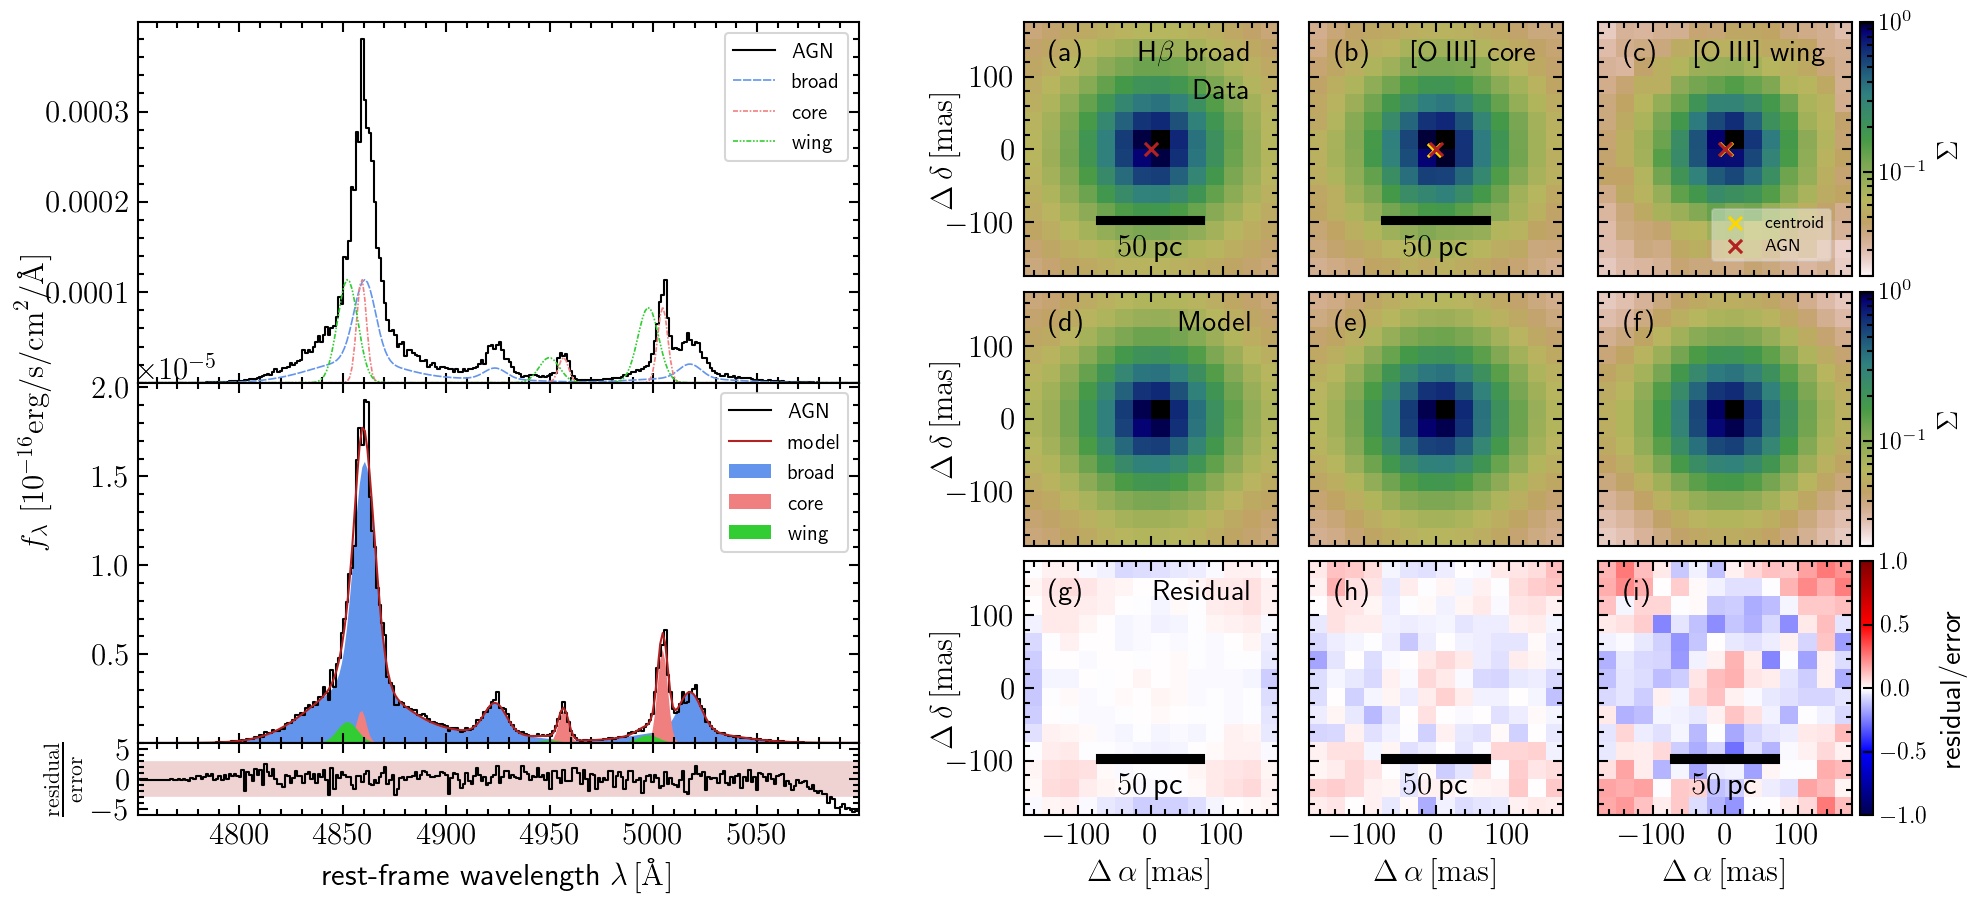

In [17]:
p = Plot(mock_astrometry)
fig = p.plot_all(mock_astrometry,[0,0])
#plt.savefig('Output/MockCube/spectroastrometry.png',bbox_inches='tight')

# Mrk 1044

In [78]:
cz = 4920
dirname = 'HE0227-0913/'
objectname = 'Mrk1044'

root = '/home/winkel/Data/MUSE/NFM/'
cubefile = root+'HE0227-0913/DataCube/Mrk_1044_DATACUBE_FINAL_2019-08-24T08:47:37.086.fits'

root2 = '/home/winkel/Projects/MUSE_NFM_AGN/'
qsotablefile = root2+'02_AGN/02_Fitting/Data/'+dirname+objectname +'.central_fit.full.fits'

astrometry = Astrometry(cubefile, qsotablefile, cz)

Setup basis


100%|██████████| 5/5 [00:00<00:00, 1626.71it/s]


Fit components to cube


100%|██████████| 14/14 [00:14<00:00,  1.02s/it]


Find PSF model parameters


100%|██████████| 2/2 [00:00<00:00, 32017.59it/s]


Find centroids


100%|██████████| 5/5 [00:29<00:00,  5.87s/it]


In [79]:
astrometry.print_result()

          broad  d = (0.00±0.01) px  = (0.00±0.18) mas = (0.00±0.06) pc
        core_Hb  d = (0.14±0.02) px  = (3.57±0.61) mas = (1.22±0.21) pc
      core_OIII  d = (0.03±0.01) px  = (0.80±0.16) mas = (0.27±0.05) pc
        wing_Hb  d = (0.08±0.02) px  = (1.94±0.58) mas = (0.67±0.20) pc
      wing_OIII  d = (0.02±0.03) px  = (0.50±0.79) mas = (0.17±0.27) pc


          broad  F = (1838.13 ± 24.48) x 10-16 ergs-1cm-2
        core_Hb  F = (90.20 ± 5.59) x 10-16 ergs-1cm-2
      core_OIII  F = (167.74 ± 2.27) x 10-16 ergs-1cm-2
        wing_Hb  F = (88.57 ± 3.92) x 10-16 ergs-1cm-2
      wing_OIII  F = (33.04 ± 3.32) x 10-16 ergs-1cm-2


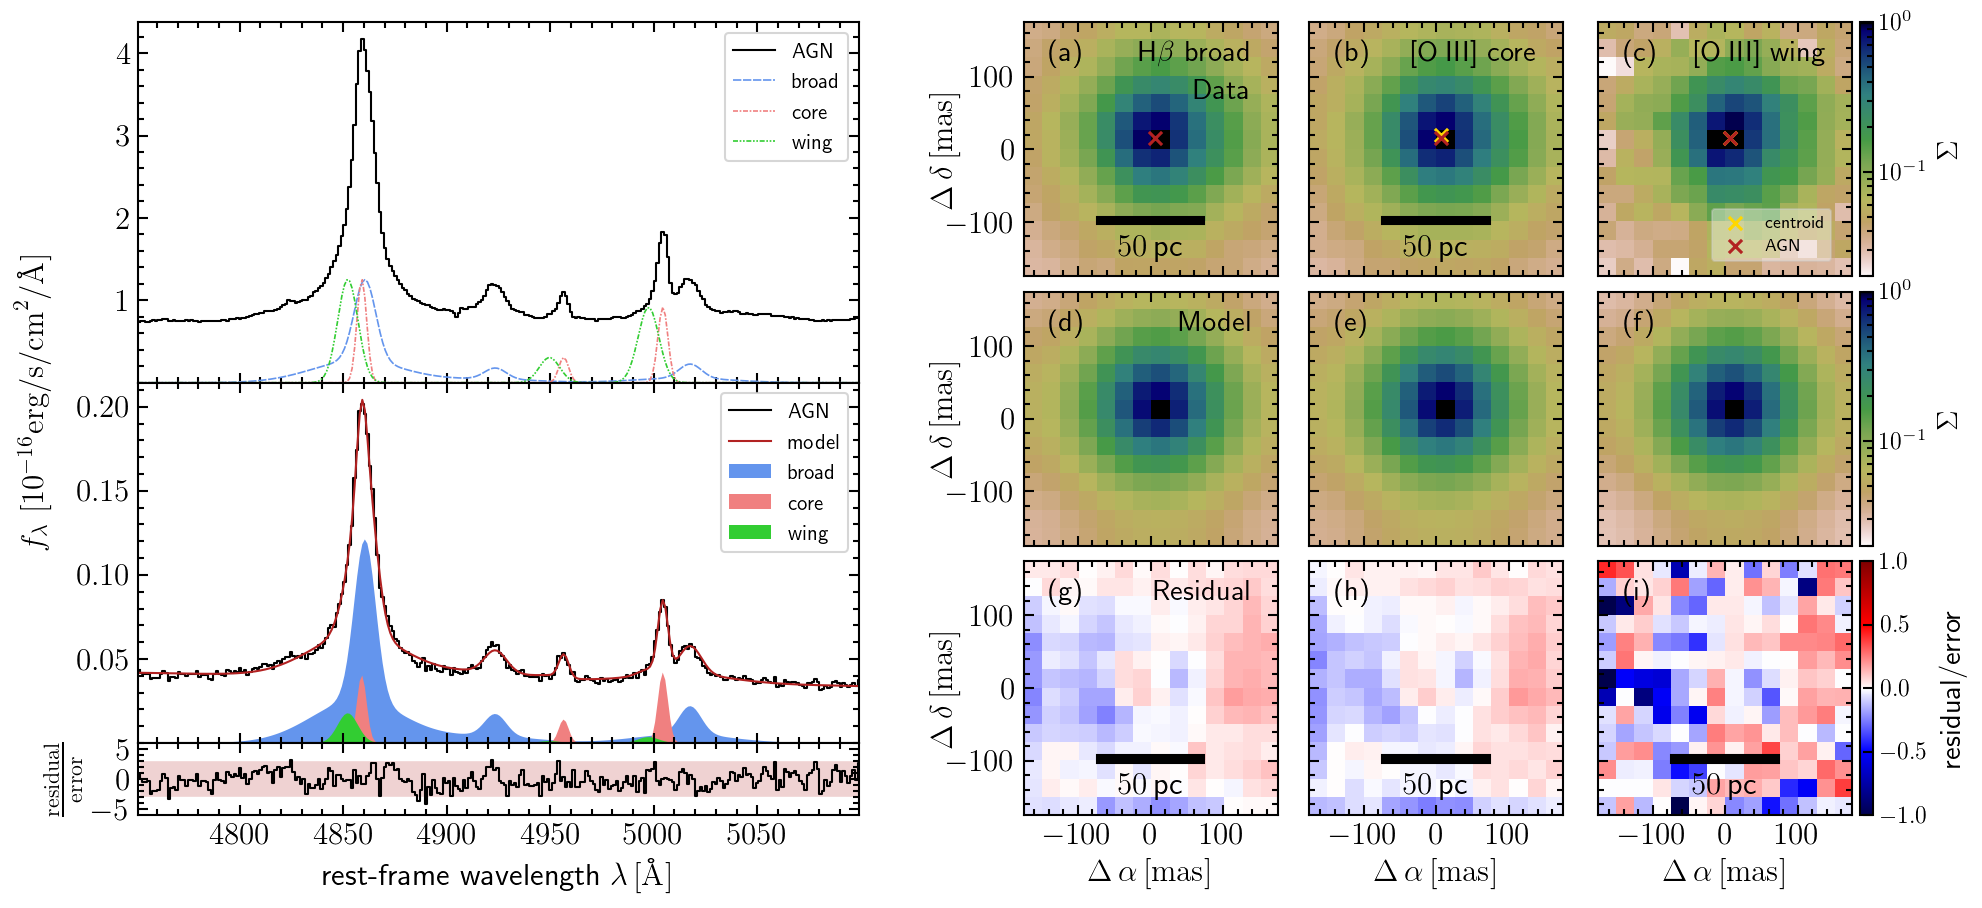

In [80]:
p = Plot(astrometry)
fig = p.plot_all(astrometry,[2,2])
plt.savefig('Output/HE0227-0913/Astrmtry_Hb/spectroastrometry.png',bbox_inches='tight')
plt.savefig('../22_Outflow_Paper/03_Analysis/Figures/spectroastrometry.png',bbox_inches='tight')

In [76]:
outfile = 'Output/HE0227-0913/Astrmtry_Hb/fluxmaps/'
astrometry.write(outfile)

# PG1126-041

In [ ]:
# PG 1126-041 
cz = 17988
dirname = 'Mrk1298/'
objectname = 'PG1126-041'

root = '/home/winkel/Data/MUSE/NFM/'
cubefile = root+'Mrk1298/DataCube/PG_1126-041_DATACUBE_FINAL_2019-04-30T01:34:36.438.fits'

root2 = '/home/winkel/Projects/MUSE_NFM_AGN/'
qsotablefile = root2+'02_AGN/02_Fitting/Data/'+dirname+objectname +'.central_fit.fits'

astrometry = Astrometry(cubefile, qsotablefile, cz)